# Difference Between Filters
Filter|State Spate| Belief|Efficiency|In Robotics
--|--|--|--|--
Histogram Filters|Discrete|Multimodel|Exponential|Approximate
Kalman Filters|Continous|Unimodal|Quadratic|Approximate
Patricle Fitlers|Continous|Multimodal|?|Approximate

**The Key Feature of Particle fitler is that is easy to program**

![](https://upload.wikimedia.org/wikipedia/commons/5/51/Particle_filters.gif)

![](https://www.google.com/url?sa=i&url=https%3A%2F%2Frobotics.stackexchange.com%2Fquestions%2F479%2Fparticle-filters-how-to-do-resampling&psig=AOvVaw0dgmmCVBghIzyF21ow_76w&ust=1627362373775000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCMDg4rr7__ECFQAAAAAdAAAAABAf)

# Import Liraries

In [1]:
from math import *
import random
import matplotlib.pyplot as plt

# Robot Class

In [2]:
class robot:
    def __init__(self):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        self.forward_noise = 0.0;
        self.turn_noise    = 0.0;
        self.sense_noise   = 0.0;
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise (ValueError, 'X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise (ValueError, 'Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise (ValueError, 'Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def move(self, turn, forward):
        if forward < 0:
            raise (ValueError, 'Robot cant move backwards')         
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size
        
        # set particle
        res = robot()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    def Gaussian(self, mu, sigma, x):
        
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
    
    
    def measurement_prob(self, measurement):
        
        # calculates how likely a measurement should be
        
        prob = 1.0;
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob
    
    
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))

In [3]:
def Show_Particles():
    plt.figure()
    plt.axis([0, world_size, 0, world_size]);
    x = []
    y = []
    for i in range(len(p)):
        x.append(p[i].x)
        y.append(p[i].y)
    plt.scatter(x, y, alpha=0.3)
    
    
    x = []
    y = []
    for i in range(len(landmarks)):
        x.append(landmarks[i][0])
        y.append(landmarks[i][1])
    plt.scatter(x, y, marker = "s", s=100)
    
    plt.scatter(myrobot.x, myrobot.y, s=100)

In [4]:
def eval(r, p):
    sum = 0.0;
    for i in range(len(p)): # calculate mean error
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = sqrt(dx * dx + dy * dy)
        sum += err
    return sum / float(len(p))

# Initialization

In [5]:
landmarks  = [[20.0, 20.0], 
              [80.0, 80.0], 
              [20.0, 80.0], 
              [80.0, 20.0]]
world_size = 100.0

# Particle Fitler

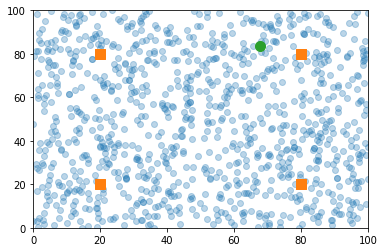

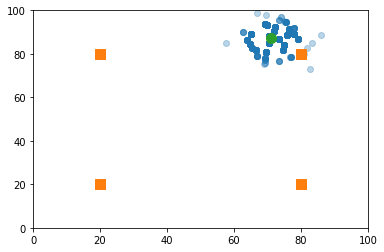

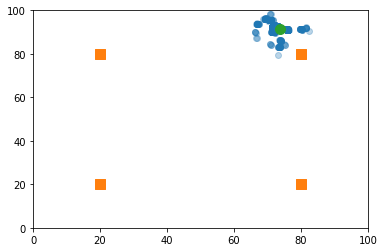

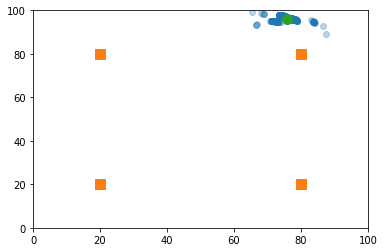

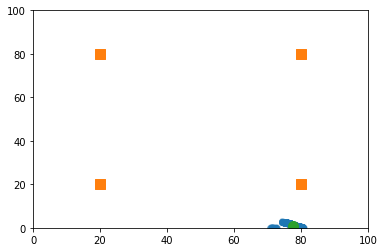

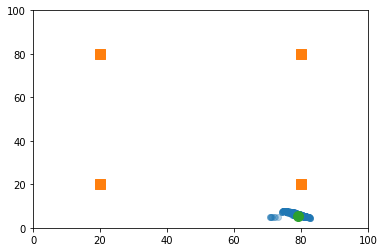

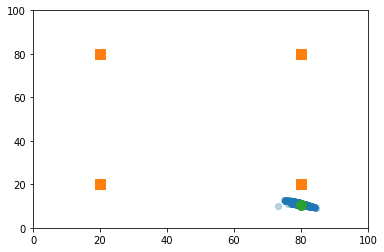

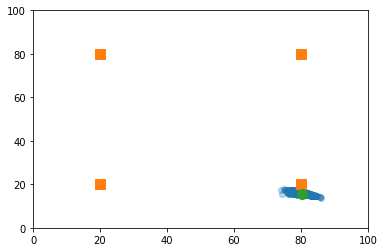

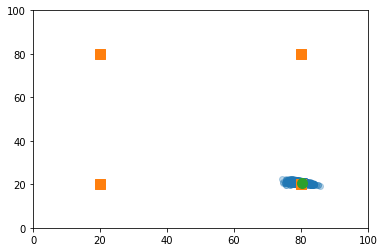

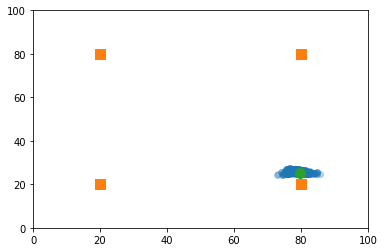

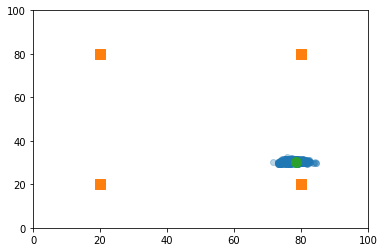

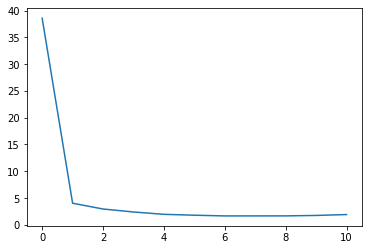

In [6]:
myrobot = robot()
N = 1000
T = 10 
Error = []
p = []
for i in range(N):
    r = robot()
    r.set_noise(0.05, 0.05, 5.0)
    p.append(r)
    
Error.append(eval(myrobot,p))
Show_Particles()
for t in range(T):
    myrobot = myrobot.move(0.1, 5.0)
    Z = myrobot.sense()

    p2 = []
    for i in range(N):
        p2.append(p[i].move(0.1, 5.0))
    p = p2

    w = []
    for i in range(N):
        w.append(p[i].measurement_prob(Z))

    p3 = []
    index = int(random.random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random.random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        p3.append(p[index])
    p = p3
    Error.append(eval(myrobot,p))
    Show_Particles()

plt.figure()
plt.plot(Error)

# Quiz: Moving Robot

In [7]:
# Make a robot called myrobot that starts at
# coordinates 30, 50 heading north (pi/2).
# Have your robot turn clockwise by pi/2, move
# 15 m, and sense. Then have it turn clockwise
# by pi/2 again, move 10 m, and sense again.
#
# Your program should print out the result of
# your two sense measurements.

In [8]:
myrobot = robot()
myrobot.set(30, 50, pi/2)
myrobot = myrobot.move(-pi/2, 15.0)
print(myrobot.sense())
myrobot = myrobot.move(-pi/2, 10.0)
print(myrobot.sense())

[39.05124837953327, 46.09772228646444, 39.05124837953327, 46.09772228646444]
[32.01562118716424, 53.150729063673246, 47.16990566028302, 40.311288741492746]


# Quiz: Add Noise

In [9]:
# Now add noise to your robot as follows:
# forward_noise = 5.0, turn_noise = 0.1,
# sense_noise = 5.0.
#
# Once again, your robot starts at 30, 50,
# heading north (pi/2), then turns clockwise
# by pi/2, moves 15 meters, senses,
# then turns clockwise by pi/2 again, moves
# 10 m, then senses again.
#
# Your program should print out the result of
# your two sense measurements.

In [10]:
myrobot = robot()
myrobot.set_noise(5.0, 0.1, 5.0)
myrobot.set(30, 50, pi/2)
myrobot = myrobot.move(-pi/2, 15.0)
print(myrobot.sense())
myrobot = myrobot.move(-pi/2, 10.0)
print(myrobot.sense())

[38.81276292033538, 34.922441466845456, 47.610123811763856, 39.99011646036406]
[34.839968224411265, 54.414793103897914, 55.11827924818546, 28.3107494424885]


# Quiz: Creating Particles

In [11]:
# Now we want to create particles,
# p[i] = robot(). In this assignment, write
# code that will assign 1000 such particles
# to a list.
#
# Your program should print out the length
# of your list (don't cheat by making an
# arbitrary list of 1000 elements!)

In [12]:
N = 1000
p = []
for i in range(N):
    x = robot()
    p.append(x)
    
print(len(p))

1000


# Quiz: Robot Praticles

In [13]:
# Now we want to simulate robot
# motion with our particles.
# Each particle should turn by 0.1
# and then move by 5. 
#
#
# Don't modify the code below. Please enter
# your code at the bottom.

In [14]:
p2 = []
for i in range(N):
    p2.append(p[i].move(0.1, 5.0))
p = p2

# Quiz: Importance Weight

In [15]:
# Now we want to give weight to our 
# particles. This program will print a
# list of 1000 particle weights.

In [16]:
myrobot = robot()
myrobot = myrobot.move(0.1, 5.0)
Z = myrobot.sense()

N = 1000
p = []
for i in range(N):
    x = robot()
    x.set_noise(0.05, 0.05, 5.0)
    p.append(x)

p2 = []
for i in range(N):
    p2.append(p[i].move(0.1, 5.0))
p = p2

w = []
for i in range(N):
    w.append(p[i].measurement_prob(Z))

In [17]:
sum(w)

0.00019593157427864178

# Quiz: New Particle

In [18]:
# In this exercise, try to write a program that
# will resample particles according to their weights.
# Particles with higher weights should be sampled
# more frequently (in proportion to their weight).

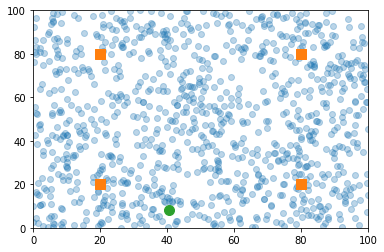

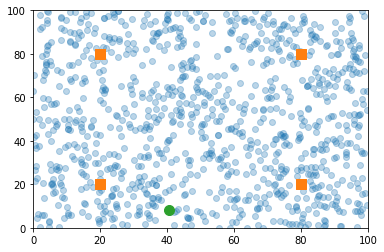

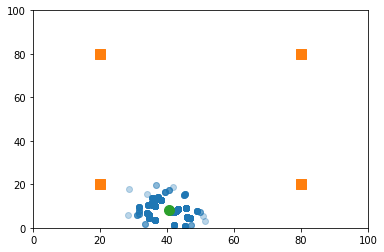

In [19]:
myrobot = robot()
myrobot = myrobot.move(0.1, 5.0)
Z = myrobot.sense()

N = 1000
p = []
for i in range(N):
    x = robot()
    x.set_noise(0.05, 0.05, 5.0)
    p.append(x)

Show_Particles()
p2 = []
for i in range(N):
    p2.append(p[i].move(0.1, 5.0))
p = p2
Show_Particles()
w = []
for i in range(N):
    w.append(p[i].measurement_prob(Z))
    
p3 = []
index = int(random.random() * N)
beta = 0.0
mw = max(w)
for i in range(N):
    beta += random.random() * 2 * mw
    while w[index] < beta:
        beta -= w[index]
        index = (index + 1) % N
    p3.append(p[index])
p = p3
Show_Particles()

# Quiz: Orientation

In [20]:
# In this exercise, write a program that will
# run your previous code twice.

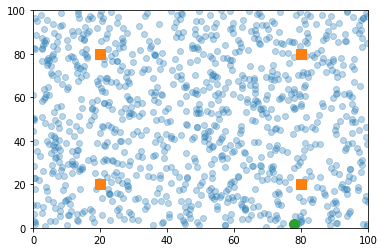

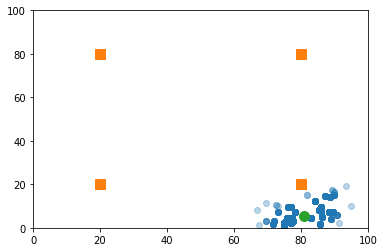

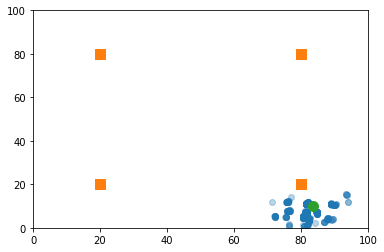

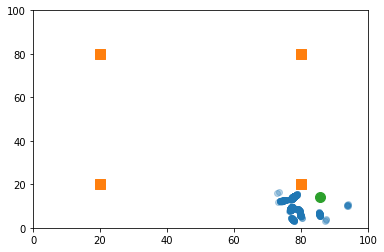

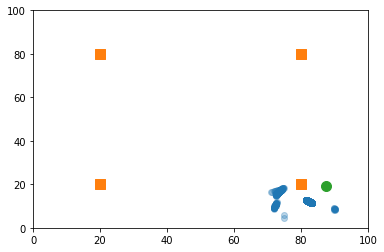

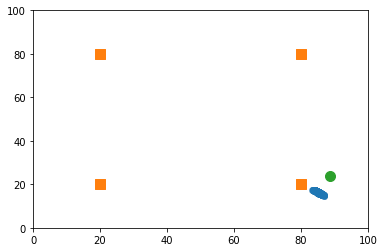

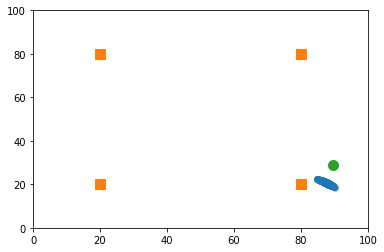

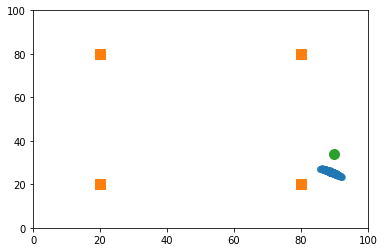

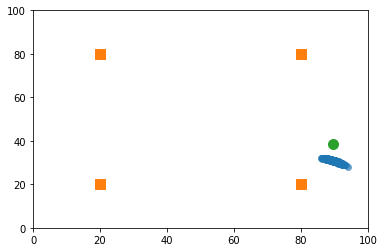

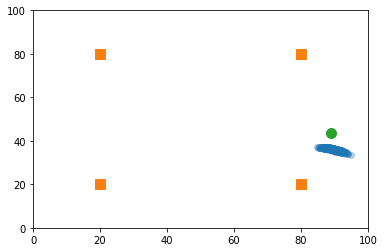

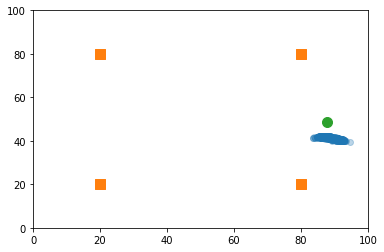

In [21]:
myrobot = robot()

N = 1000
T = 10
p = []
for i in range(N):
    x = robot()
    x.set_noise(0.05, 0.05, 5.0)
    p.append(x)

Show_Particles()    
    
for t in range(T):    
    myrobot = myrobot.move(0.1, 5.0)
    Z = myrobot.sense()
    p2 = []
    for i in range(N):
        p2.append(p[i].move(0.1, 5.0))
    p = p2

    w = []
    for i in range(N):
        w.append(p[i].measurement_prob(Z))

    p3 = []
    index = int(random.random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random.random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        p3.append(p[index])
    p = p3
    Show_Particles()

# Quiz: Error

In [22]:
myrobot = robot()
myrobot = myrobot.move(0.1, 5.0)
Z = myrobot.sense()
N = 1000
T = 10 #Leave this as 10 for grading purposes.

p = []
for i in range(N):
    r = robot()
    r.set_noise(0.05, 0.05, 5.0)
    p.append(r)

for t in range(T):
    myrobot = myrobot.move(0.1, 5.0)
    Z = myrobot.sense()

    p2 = []
    for i in range(N):
        p2.append(p[i].move(0.1, 5.0))
    p = p2

    w = []
    for i in range(N):
        w.append(p[i].measurement_prob(Z))

    p3 = []
    index = int(random.random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random.random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        p3.append(p[index])
    p = p3
    print(eval(myrobot,p))

5.579952521218688
6.154769199778422
7.4135755531616345
6.548291884479038
6.511767481975285
5.5022569564632295
5.75405335897305
5.998815441916882
6.1287567262735765
5.95394351188977


![](https://i.stack.imgur.com/YylQT.gif)